In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
import copy
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print(device)

cuda:0


In [3]:
classes=['Covid','No Covid']
num_classes=2
batch_size=4

In [4]:
# reshape all images to 64x64 and apply tensor transformation
dataset = torchvision.datasets.ImageFolder(root="./Full",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227])
                                                            # transforms.Grayscale(num_output_channels=1)
                                                            ]))
# testset = torchvision.datasets.ImageFolder(root="./xray",train=False,transform=transforms.Compose([transforms.Resize([300,305]),transforms.ToTensor()]))
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

In [5]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False)
print(len(trainset)/batch_size,len(testset)/batch_size)

8088
1617.5 404.5


In [6]:
class CNN(nn.Module):
    def get_first_FC_Layer(self,x):
            x=self.representation_network(x).flatten(1)
            x=self.classification_network[0](x)
            return x;
    def get_Representation_Net(self,x):
            x=self.representation_network(x).flatten(1)
            return  x;
    def __init__(self):
        super(CNN,self).__init__()
        self.representation_network=nn.Sequential(
            nn.Conv2d(3,32,3), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Dropout(p=0.2),
            nn.Conv2d(32,32,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Dropout(p=0.2)
        )
        self.classification_network=nn.Sequential(
            nn.Linear(18432,128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128,1)
        )
    def forward(self,x):
#         print(x.shape)
        x=self.representation_network(x)
#         print(x.shape)
        # flattening of the vector=> same dimension of first index(batch size) , everythign else is flattened(-1)
        x=x.view(x.size(0),-1)
#         print(x.shape)
        x=self.classification_network(x)
#         print(x.shape)
        return x

In [7]:
net = CNN()
net.load_state_dict(torch.load("./CNN5.pth").state_dict())

<All keys matched successfully>

In [8]:
def evaluation(dataloader,model):
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
    print(correct,total)
    model.train()
    return 100*correct/total

In [9]:
%%notify -m "Completed"

X_Train=np.empty((0,128))
Y_Train=np.empty((0,batch_size))
print(X_Train.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=net.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train=np.append(X_Train,FCLayer,axis=0)
    Y_Train=np.append(Y_Train,labels.numpy())
print(X_Train.shape,Y_Train.shape)

(0, 128)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [10]:
%%notify -m "Completed"
X_Test=np.empty((0,128))
Y_Test=np.empty((0,batch_size))
print(X_Test.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=net.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test=np.append(X_Test,FCLayer,axis=0)
    Y_Test=np.append(Y_Test,labels.numpy())
print(X_Test.shape,Y_Test.shape)

(0, 128)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

In [11]:
%%notify -m "Completed"
X_Train_FeatureMap=np.empty((0,18432))
Y_Train_FeatureMap=np.empty((0,batch_size))
print(X_Train_FeatureMap.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featureMap=net.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train_FeatureMap=np.append(X_Train_FeatureMap,featureMap,axis=0)
    Y_Train_FeatureMap=np.append(Y_Train_FeatureMap,labels.numpy())
print(X_Train_FeatureMap.shape,Y_Train_FeatureMap.shape)

(0, 18432)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the b

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [12]:
%%notify -m "Completed"
X_Test_FeatureMap=np.empty((0,18432))
Y_Test_FeatureMap=np.empty((0,batch_size))
print(X_Test_FeatureMap.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featuremap=net.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test_FeatureMap=np.append(X_Test_FeatureMap,featuremap,axis=0)
    Y_Test_FeatureMap=np.append(Y_Test_FeatureMap,labels.numpy())
print(X_Test_FeatureMap.shape,Y_Test_FeatureMap.shape)

(0, 18432)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the b

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

In [14]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-2,0.1,1,10],
                     'C': [0.001,0.1,1, 10, 100],
}
# tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3],
#                      'C': [0.001],
#                    }
clf = GridSearchCV(
        SVC(), tuned_parameters, scoring= 'accuracy',verbose=10
    )
clf.fit(X_Train, Y_Train.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 1/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.662 total time=   4.0s
[CV 2/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 2/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.662 total time=   4.0s
[CV 3/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 3/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.668 total time=   4.0s
[CV 4/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 4/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.662 total time=   4.1s
[CV 5/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 5/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.657 total time=   4.0s
[CV 1/5; 2/25] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 1/5; 2/25] END C=0.001,

[CV 1/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.951 total time=   0.8s
[CV 2/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 2/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.964 total time=   0.8s
[CV 3/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 3/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.950 total time=   0.8s
[CV 4/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 4/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.951 total time=   0.8s
[CV 5/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 5/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.958 total time=   0.9s
[CV 1/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 1/5; 12/25] END C=1, gamma=0.01, kernel=rbf;, score=0.920 total time=   3.9s
[CV 2/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 2/5; 12/25] END C=1

[CV 2/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.955 total time=   0.8s
[CV 3/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 3/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.949 total time=   0.8s
[CV 4/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 4/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.941 total time=   0.8s
[CV 5/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 5/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.939 total time=   0.8s
[CV 1/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 1/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.920 total time=   3.5s
[CV 2/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 2/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.914 total time=   3.6s
[CV 3/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 3/5; 22/

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=10)

In [14]:
def k_fold_cv_svm(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        clf=SVC(C=1,kernel='rbf',gamma=0.001)
        clf.fit(X_train,y_train.ravel())
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [15]:
clf=k_fold_cv_svm(X_Train,Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Accuracy: 94.66769706336939
FOLD 1
--------------------------------
Accuracy: 95.6723338485317
FOLD 2
--------------------------------
Accuracy: 95.44049459041732
FOLD 3
--------------------------------
Accuracy: 95.5950540958269
FOLD 4
--------------------------------
Accuracy: 95.13137557959814
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 94.66769706336939 %
Fold 1: 95.6723338485317 %
Fold 2: 95.44049459041732 %
Fold 3: 95.5950540958269 %
Fold 4: 95.13137557959814 %
Average: 95.30139103554868 %
Accuracy:  0.9252163164400494
Precision:  0.9234507897934386
Recall:  0.9290953545232273
F1-Score:  0.9262644728823888
AUC:  0.9251726772616137


In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
def k_fold_cv_dtree(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        decision_tree = DecisionTreeClassifier(random_state=102)
        decision_tree = decision_tree.fit(X_train, y_train.ravel())
        y_pred = decision_tree.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del decision_tree
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return decision_tree

In [18]:
dtree=k_fold_cv_dtree(X_Train,Y_Train.ravel())
y_pred=dtree.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Accuracy: 92.50386398763524
FOLD 1
--------------------------------
Accuracy: 91.80834621329211
FOLD 2
--------------------------------
Accuracy: 91.57650695517773
FOLD 3
--------------------------------
Accuracy: 92.19474497681608
FOLD 4
--------------------------------
Accuracy: 90.49459041731066
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 92.50386398763524 %
Fold 1: 91.80834621329211 %
Fold 2: 91.57650695517773 %
Fold 3: 92.19474497681608 %
Fold 4: 90.49459041731066 %
Average: 91.71561051004637 %
Accuracy:  0.8751545117428925
Precision:  0.8746958637469586
Recall:  0.8789731051344744
F1-Score:  0.8768292682926829
AUC:  0.875111552567237


In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
def k_fold_cv_rforest(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
        random_forest = random_forest.fit(X_train, y_train.ravel())
        y_pred = random_forest.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del random_forest
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return random_forest

In [21]:
random_forest=k_fold_cv_rforest(X_Train,Y_Train.ravel())
y_pred=random_forest.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Accuracy: 94.97681607418856
FOLD 1
--------------------------------
Accuracy: 96.21329211746522
FOLD 2
--------------------------------
Accuracy: 95.5177743431221
FOLD 3
--------------------------------
Accuracy: 96.05873261205564
FOLD 4
--------------------------------
Accuracy: 95.28593508500772
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 94.97681607418856 %
Fold 1: 96.21329211746522 %
Fold 2: 95.5177743431221 %
Fold 3: 96.05873261205564 %
Fold 4: 95.28593508500772 %
Average: 95.61051004636785 %
Accuracy:  0.9239802224969098
Precision:  0.9222357229647631
Recall:  0.9278728606356969
F1-Score:  0.9250457038391224
AUC:  0.9239364303178484


In [22]:
import xgboost as xgb


In [23]:
def k_fold_cv_xgb(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        eval_set = [(X_train, y_train.ravel()), (X_test, y_test)]
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
        xg_cl.fit(X_train,y_train.ravel())
        y_pred = xg_cl.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del xg_cl
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return xg_cl

In [24]:
xg=k_fold_cv_xgb(X_Train,Y_Train.ravel())
y_pred=xg.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
[16:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 96.29057187017001
FOLD 1
--------------------------------
[16:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 95.5950540958269
FOLD 2
--------------------------------
[16:14:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

In [25]:
from sklearn.neural_network import MLPClassifier

In [26]:
def k_fold_cv_mlp(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        clf = MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [27]:
clf=k_fold_cv_mlp(X_Train,Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test,y_pred))
print("Precision: ",precision_score(Y_Test,y_pred))
print("Recall: ",recall_score(Y_Test,y_pred))
print("F1-Score: ",f1_score(Y_Test,y_pred))
print("AUC: ",roc_auc_score(Y_Test,y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 0.35446344
Iteration 2, loss = 0.19986715
Iteration 3, loss = 0.16539245
Iteration 4, loss = 0.15076069
Iteration 5, loss = 0.13701297
Iteration 6, loss = 0.12803875
Iteration 7, loss = 0.12197622
Iteration 8, loss = 0.11623740
Iteration 9, loss = 0.11166087
Iteration 10, loss = 0.10750488
Iteration 11, loss = 0.10751888
Iteration 12, loss = 0.10077622
Iteration 13, loss = 0.09998649
Iteration 14, loss = 0.09618960
Iteration 15, loss = 0.09507172
Iteration 16, loss = 0.09052803
Iteration 17, loss = 0.08977280
Iteration 18, loss = 0.08726004
Iteration 19, loss = 0.08490146
Iteration 20, loss = 0.08341297
Iteration 21, loss = 0.08340098
Iteration 22, loss = 0.07912934
Iteration 23, loss = 0.07891561
Iteration 24, loss = 0.07833199
Iteration 25, loss = 0.07749519
Iteration 26, loss = 0.07227590
Iteration 27, loss = 0.07705442
Iteration 28, loss = 0.06854013
Iteration 29, loss = 0.06961432
Iteration 30, loss = 0.06889640
Iteration

Iteration 55, loss = 0.04795027
Iteration 56, loss = 0.04847133
Iteration 57, loss = 0.04610166
Iteration 58, loss = 0.04761548
Iteration 59, loss = 0.04995240
Iteration 60, loss = 0.04690766
Iteration 61, loss = 0.04832742
Iteration 62, loss = 0.04174305
Iteration 63, loss = 0.04159104
Iteration 64, loss = 0.04030367
Iteration 65, loss = 0.04043935
Iteration 66, loss = 0.04025891
Iteration 67, loss = 0.03981869
Iteration 68, loss = 0.04175576
Iteration 69, loss = 0.04238040
Iteration 70, loss = 0.03972514
Iteration 71, loss = 0.03711967
Iteration 72, loss = 0.04184303
Iteration 73, loss = 0.04220345
Iteration 74, loss = 0.03902865
Iteration 75, loss = 0.03567591
Iteration 76, loss = 0.03741101
Iteration 77, loss = 0.03775305
Iteration 78, loss = 0.03472754
Iteration 79, loss = 0.03279748
Iteration 80, loss = 0.03418811
Iteration 81, loss = 0.03258143
Iteration 82, loss = 0.03504288
Iteration 83, loss = 0.03218853
Iteration 84, loss = 0.03044157
Iteration 85, loss = 0.02992017
Iteratio

Iteration 120, loss = 0.01693820
Iteration 121, loss = 0.02328101
Iteration 122, loss = 0.02111618
Iteration 123, loss = 0.01685503
Iteration 124, loss = 0.01531138
Iteration 125, loss = 0.01458319
Iteration 126, loss = 0.01666959
Iteration 127, loss = 0.01702951
Iteration 128, loss = 0.01472977
Iteration 129, loss = 0.01472458
Iteration 130, loss = 0.01350658
Iteration 131, loss = 0.01328011
Iteration 132, loss = 0.01323590
Iteration 133, loss = 0.01259342
Iteration 134, loss = 0.01226296
Iteration 135, loss = 0.01459705
Iteration 136, loss = 0.01361591
Iteration 137, loss = 0.01257946
Iteration 138, loss = 0.01227878
Iteration 139, loss = 0.01207211
Iteration 140, loss = 0.01218122
Iteration 141, loss = 0.01344296
Iteration 142, loss = 0.01190300
Iteration 143, loss = 0.01150483
Iteration 144, loss = 0.01149873
Iteration 145, loss = 0.01183227
Iteration 146, loss = 0.01259920
Iteration 147, loss = 0.01248143
Iteration 148, loss = 0.01210074
Iteration 149, loss = 0.01150942
Iteration 

Iteration 86, loss = 0.02822873
Iteration 87, loss = 0.03305200
Iteration 88, loss = 0.02907720
Iteration 89, loss = 0.02681612
Iteration 90, loss = 0.02653276
Iteration 91, loss = 0.02484566
Iteration 92, loss = 0.02469232
Iteration 93, loss = 0.03029721
Iteration 94, loss = 0.02654626
Iteration 95, loss = 0.02702421
Iteration 96, loss = 0.02456772
Iteration 97, loss = 0.02275822
Iteration 98, loss = 0.02213074
Iteration 99, loss = 0.02344573
Iteration 100, loss = 0.02310169
Iteration 101, loss = 0.02234413
Iteration 102, loss = 0.02310854
Iteration 103, loss = 0.02122653
Iteration 104, loss = 0.02008821
Iteration 105, loss = 0.02038757
Iteration 106, loss = 0.02037250
Iteration 107, loss = 0.02096869
Iteration 108, loss = 0.02072672
Iteration 109, loss = 0.02039611
Iteration 110, loss = 0.02192305
Iteration 111, loss = 0.02412938
Iteration 112, loss = 0.02207645
Iteration 113, loss = 0.02120090
Iteration 114, loss = 0.02022364
Iteration 115, loss = 0.02030466
Training loss did not im

In [28]:
from sklearn.decomposition import KernelPCA

Text(0, 0.5, 'cumulative explained variance')

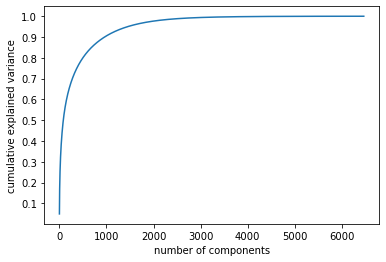

In [32]:
kpca = KernelPCA(kernel = 'rbf')
kpca_transform = kpca.fit_transform(X_Train_FeatureMap)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [29]:
kpca = KernelPCA(kernel = 'rbf',n_components=5000)
X_Train_Transformed_FeatureMap = kpca.fit_transform(X_Train_FeatureMap)
print(X_Train_Transformed_FeatureMap.shape)

(6470, 5000)


In [30]:
X_Test_Transformed_FeatureMap = kpca.transform(X_Test_FeatureMap)

print(X_Test_FeatureMap.shape,X_Test_Transformed_FeatureMap.shape)

(1618, 18432) (1618, 5000)


In [31]:
# %% notify -m "GridCV"
tuned_parameters = {'kernel': ['rbf'], 'gamma': [10,100],
                     'C': [10],
}
clf = GridSearchCV(
        SVC(), tuned_parameters, scoring= 'accuracy',verbose=10
    )
clf.fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 1/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.904 total time= 1.2min
[CV 2/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 2/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.913 total time= 1.5min
[CV 3/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 3/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.906 total time= 1.2min
[CV 4/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 4/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.911 total time= 1.4min
[CV 5/5; 1/2] START C=10, gamma=10, kernel=rbf..................................
[CV 5/5; 1/2] END ...C=10, gamma=10, kernel=rbf;, score=0.914 total time= 1.4min
[CV 1/5; 2/2] START C=10, gamma=100, kernel=rbf.................................
[CV 1/5; 2/2] END ..C=10, gamma=100, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [10], 'gamma': [10, 100], 'kernel': ['rbf']},
             scoring='accuracy', verbose=10)

In [32]:
clf=k_fold_cv_svm(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 47.68160741885626
FOLD 1
--------------------------------
Accuracy: 49.84544049459041
FOLD 2
--------------------------------
Accuracy: 50.23183925811438
FOLD 3
--------------------------------
Accuracy: 48.76352395672334
FOLD 4
--------------------------------
Accuracy: 48.29984544049459
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 47.68160741885626 %
Fold 1: 49.84544049459041 %
Fold 2: 50.23183925811438 %
Fold 3: 48.76352395672334 %
Fold 4: 48.29984544049459 %
Average: 48.964451313755795 %
Accuracy:  0.5055624227441285
Precision:  0.5055624227441285
Recall:  1.0
F1-Score:  0.671592775041051
AUC:  0.5


In [33]:
dtree=k_fold_cv_dtree(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=dtree.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 77.58887171561051
FOLD 1
--------------------------------
Accuracy: 76.50695517774344
FOLD 2
--------------------------------
Accuracy: 76.42967542503864
FOLD 3
--------------------------------
Accuracy: 78.20710973724884
FOLD 4
--------------------------------
Accuracy: 78.516228748068
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 77.58887171561051 %
Fold 1: 76.50695517774344 %
Fold 2: 76.42967542503864 %
Fold 3: 78.20710973724884 %
Fold 4: 78.516228748068 %
Average: 77.44976816074188 %
Accuracy:  0.565512978986403
Precision:  0.5897035881435257
Recall:  0.4621026894865526
F1-Score:  0.5181631254283756
AUC:  0.5666763447432763


In [34]:
xg=k_fold_cv_xgb(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=xg.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
[17:12:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88.79443585780525
FOLD 1
--------------------------------
[17:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88.79443585780525
FOLD 2
--------------------------------
[17:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

In [35]:
clf=k_fold_cv_mlp(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 0.69496691
Iteration 2, loss = 0.68602978
Iteration 3, loss = 0.67716084
Iteration 4, loss = 0.66475774
Iteration 5, loss = 0.64840574
Iteration 6, loss = 0.62808971
Iteration 7, loss = 0.60389605
Iteration 8, loss = 0.57705726
Iteration 9, loss = 0.54799314
Iteration 10, loss = 0.51792518
Iteration 11, loss = 0.48727857
Iteration 12, loss = 0.45707695
Iteration 13, loss = 0.42853071
Iteration 14, loss = 0.40154187
Iteration 15, loss = 0.37638929
Iteration 16, loss = 0.35343965
Iteration 17, loss = 0.33240787
Iteration 18, loss = 0.31387806
Iteration 19, loss = 0.29616926
Iteration 20, loss = 0.28072252
Iteration 21, loss = 0.26651704
Iteration 22, loss = 0.25371662
Iteration 23, loss = 0.24221590
Iteration 24, loss = 0.23133449
Iteration 25, loss = 0.22148709
Iteration 26, loss = 0.21261788
Iteration 27, loss = 0.20434503
Iteration 28, loss = 0.19664487
Iteration 29, loss = 0.18957304
Iteration 30, loss = 0.18396195
Iteration

Iteration 252, loss = 0.01918670
Iteration 253, loss = 0.01915714
Iteration 254, loss = 0.01896634
Iteration 255, loss = 0.01885578
Iteration 256, loss = 0.01876318
Iteration 257, loss = 0.01869563
Iteration 258, loss = 0.01868129
Iteration 259, loss = 0.01860498
Iteration 260, loss = 0.01863018
Iteration 261, loss = 0.01844488
Iteration 262, loss = 0.01841199
Iteration 263, loss = 0.01827058
Iteration 264, loss = 0.01823431
Iteration 265, loss = 0.01817303
Iteration 266, loss = 0.01801687
Iteration 267, loss = 0.01797532
Iteration 268, loss = 0.01783167
Iteration 269, loss = 0.01781199
Iteration 270, loss = 0.01778526
Iteration 271, loss = 0.01773800
Iteration 272, loss = 0.01764651
Iteration 273, loss = 0.01755173
Iteration 274, loss = 0.01741415
Iteration 275, loss = 0.01733452
Iteration 276, loss = 0.01725941
Iteration 277, loss = 0.01722469
Iteration 278, loss = 0.01713883
Iteration 279, loss = 0.01709782
Iteration 280, loss = 0.01705626
Iteration 281, loss = 0.01704459
Iteration 

Iteration 153, loss = 0.03238269
Iteration 154, loss = 0.03198002
Iteration 155, loss = 0.03170943
Iteration 156, loss = 0.03141435
Iteration 157, loss = 0.03131333
Iteration 158, loss = 0.03102996
Iteration 159, loss = 0.03100964
Iteration 160, loss = 0.03062282
Iteration 161, loss = 0.03047854
Iteration 162, loss = 0.03041732
Iteration 163, loss = 0.03015073
Iteration 164, loss = 0.02992047
Iteration 165, loss = 0.02969125
Iteration 166, loss = 0.02947147
Iteration 167, loss = 0.02928698
Iteration 168, loss = 0.02917269
Iteration 169, loss = 0.02898835
Iteration 170, loss = 0.02878641
Iteration 171, loss = 0.02860880
Iteration 172, loss = 0.02850788
Iteration 173, loss = 0.02823488
Iteration 174, loss = 0.02827265
Iteration 175, loss = 0.02804561
Iteration 176, loss = 0.02779774
Iteration 177, loss = 0.02771159
Iteration 178, loss = 0.02753285
Iteration 179, loss = 0.02733363
Iteration 180, loss = 0.02713400
Iteration 181, loss = 0.02700716
Iteration 182, loss = 0.02693785
Iteration 

Iteration 72, loss = 0.07086603
Iteration 73, loss = 0.06992739
Iteration 74, loss = 0.06872325
Iteration 75, loss = 0.06773592
Iteration 76, loss = 0.06674558
Iteration 77, loss = 0.06603873
Iteration 78, loss = 0.06500719
Iteration 79, loss = 0.06425046
Iteration 80, loss = 0.06291996
Iteration 81, loss = 0.06211330
Iteration 82, loss = 0.06134113
Iteration 83, loss = 0.06063454
Iteration 84, loss = 0.05972397
Iteration 85, loss = 0.05909357
Iteration 86, loss = 0.05827899
Iteration 87, loss = 0.05743162
Iteration 88, loss = 0.05663397
Iteration 89, loss = 0.05627286
Iteration 90, loss = 0.05525024
Iteration 91, loss = 0.05465262
Iteration 92, loss = 0.05400940
Iteration 93, loss = 0.05334050
Iteration 94, loss = 0.05261399
Iteration 95, loss = 0.05203164
Iteration 96, loss = 0.05142033
Iteration 97, loss = 0.05085688
Iteration 98, loss = 0.05039455
Iteration 99, loss = 0.04983473
Iteration 100, loss = 0.04916602
Iteration 101, loss = 0.04891365
Iteration 102, loss = 0.04819790
Itera

Iteration 322, loss = 0.01414818
Iteration 323, loss = 0.01410859
Iteration 324, loss = 0.01404339
Iteration 325, loss = 0.01397991
Iteration 326, loss = 0.01412820
Iteration 327, loss = 0.01403822
Iteration 328, loss = 0.01384265
Iteration 329, loss = 0.01378380
Iteration 330, loss = 0.01372669
Iteration 331, loss = 0.01364607
Iteration 332, loss = 0.01363555
Iteration 333, loss = 0.01365006
Iteration 334, loss = 0.01350477
Iteration 335, loss = 0.01351448
Iteration 336, loss = 0.01344409
Iteration 337, loss = 0.01341223
Iteration 338, loss = 0.01333541
Iteration 339, loss = 0.01334121
Iteration 340, loss = 0.01326665
Iteration 341, loss = 0.01322336
Iteration 342, loss = 0.01313701
Iteration 343, loss = 0.01313196
Iteration 344, loss = 0.01307009
Iteration 345, loss = 0.01307590
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 87.24884080370943
FOLD 3
--------------------------------
Iteration 1, loss = 0.69470357
Iteration 2, loss =

Iteration 224, loss = 0.02095865
Iteration 225, loss = 0.02080805
Iteration 226, loss = 0.02082169
Iteration 227, loss = 0.02069594
Iteration 228, loss = 0.02052741
Iteration 229, loss = 0.02046847
Iteration 230, loss = 0.02033612
Iteration 231, loss = 0.02026623
Iteration 232, loss = 0.02016254
Iteration 233, loss = 0.02007956
Iteration 234, loss = 0.02001989
Iteration 235, loss = 0.01993401
Iteration 236, loss = 0.01981493
Iteration 237, loss = 0.01977930
Iteration 238, loss = 0.01969601
Iteration 239, loss = 0.01954385
Iteration 240, loss = 0.01950437
Iteration 241, loss = 0.01969420
Iteration 242, loss = 0.01949508
Iteration 243, loss = 0.01937883
Iteration 244, loss = 0.01919508
Iteration 245, loss = 0.01921369
Iteration 246, loss = 0.01901015
Iteration 247, loss = 0.01898396
Iteration 248, loss = 0.01891066
Iteration 249, loss = 0.01882012
Iteration 250, loss = 0.01876445
Iteration 251, loss = 0.01856641
Iteration 252, loss = 0.01855665
Iteration 253, loss = 0.01841109
Iteration 

Iteration 182, loss = 0.02576360
Iteration 183, loss = 0.02555292
Iteration 184, loss = 0.02534721
Iteration 185, loss = 0.02533031
Iteration 186, loss = 0.02506326
Iteration 187, loss = 0.02499971
Iteration 188, loss = 0.02487833
Iteration 189, loss = 0.02473813
Iteration 190, loss = 0.02494206
Iteration 191, loss = 0.02460337
Iteration 192, loss = 0.02435058
Iteration 193, loss = 0.02420975
Iteration 194, loss = 0.02411635
Iteration 195, loss = 0.02397669
Iteration 196, loss = 0.02380620
Iteration 197, loss = 0.02373515
Iteration 198, loss = 0.02376252
Iteration 199, loss = 0.02372071
Iteration 200, loss = 0.02341572
Iteration 201, loss = 0.02325714
Iteration 202, loss = 0.02315352
Iteration 203, loss = 0.02312526
Iteration 204, loss = 0.02297449
Iteration 205, loss = 0.02284958
Iteration 206, loss = 0.02268991
Iteration 207, loss = 0.02262180
Iteration 208, loss = 0.02249471
Iteration 209, loss = 0.02250662
Iteration 210, loss = 0.02231958
Iteration 211, loss = 0.02218618
Iteration 

In [36]:
random_forest=k_fold_cv_rforest(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=random_forest.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 81.76197836166924
FOLD 1
--------------------------------
Accuracy: 81.68469860896445
FOLD 2
--------------------------------
Accuracy: 80.75734157650696
FOLD 3
--------------------------------
Accuracy: 82.61205564142195
FOLD 4
--------------------------------
Accuracy: 80.370942812983
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 81.76197836166924 %
Fold 1: 81.68469860896445 %
Fold 2: 80.75734157650696 %
Fold 3: 82.61205564142195 %
Fold 4: 80.370942812983 %
Average: 81.43740340030912 %
Accuracy:  0.6687268232385661
Precision:  0.7067448680351907
Recall:  0.589242053789731
F1-Score:  0.6426666666666666
AUC:  0.6696210268948656
